# Prédiction de revenus : cibler de nouveaux clients potentiels 
*Etude data - Projet 7 - Nicolas Pasero (avril 2020)*\
*OpenClassrooms - ENSAE-ENSAI Formation Continue*\
*Traitement des données sur Jupyter Notebook (Distribution Anaconda)*\
*Etude réalisée en langage Python*

*Data source 1:* [Fichier des données de la World Income Distribution, datée de 2008](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/data-projet7.csv)\
*Data source 2:* [Indices de Gini estimés par la Banque mondiale](http://data.worldbank.org/indicator/SI.POV.GINI)

---

### Rappel du contexte
Employé dans une banque, présente dans de nombreux pays à travers le monde. Celle-ci souhaite cibler de nouveaux clients potentiels, plus particulièrement les jeunes en âge d'ouvrir leur tout premier compte bancaire.

Cependant, elle souhaite *cibler les prospects les plus susceptibles d'avoir, plus tard dans leur vie, de hauts revenus*.

**La mission confiée à mon équipe est de créer un modèle permettant de déterminer le revenu potentiel d'une personne.**

"Quelles informations avons-nous ?" Uniquement le revenu des parents, car nous allons cibler les enfants de nos clients actuels, ainsi que le pays où ils habitent. Et une dernière chose : ce modèle doit être valable pour la plupart des pays du monde. 

Avec aussi peu de données disponibles, cela semble être un sacré challenge !

Ainsi, le modèle proposé sera une régression linéaire avec 3 variables :

- le revenu des parents (nos clients actuels);
- le revenu moyen du pays dans lequel habite le prospect;
- l'indice de Gini calculé sur les revenus des habitants du pays en question. 

**L'unité utilisée dans la colonne income de la World Income Distribution est le $PPP. Cette unité est calculée par la Banque mondiale, selon la méthode Eltöte-Köves-Szulc.**

Purchasing Power Parity (PPP) = Parité du Pouvoir d'Achat (PPA)\
La PPA est une méthode utilisée en économie pour établir une comparaison entre pays du pouvoir d'achat des devises nationales, une simple utilisation des taux de change ne permet pas de le faire.

Le pouvoir d'achat d’une quantité donnée d’argent dépend en effet du coût de la vie, c’est-à-dire du niveau général des prix. La PPA permet de mesurer combien une devise permet d’acheter de biens et services dans chacune des zones que l’on compare.

Les économistes forment un « panier » normalisé de biens et de services, dont le contenu peut être sujet à caution.

La monnaie couramment utilisée comme référence est le dollar américain, pris à une année donnée.

**La population de l'échantillon a été découpée en quantiles.**\
Nous appellerons ici chaque quantile une classe de revenu. Ainsi, la valeur de la colonne *income* pour un quantile donné peut être vu comme le revenu moyen des personnes appartenant à la classe de revenu correspondante à ce quantile.

**Ici les données de la World Income Distribution présentent pour chaque pays les centiles de la distribution des revenus de leur population respective.**

---

## Traitement des données 

In [168]:
#Librairies Python pour le traitement des données
import pandas as pd
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster, metrics
from sklearn.metrics import pairwise_distances_argmin_min
from statsmodels.graphics.gofplots import ProbPlot

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Style graphique utilisé pour les visualisations
plt.style.use('ggplot')

In [3]:
#Chargement du dataset 'data-projet7.csv'
#Fichier de la World Income Distribution
data = pd.read_csv('p7_data/data-projet7.csv', decimal=",")
display(data.head())
display(data.shape)

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


(11599, 6)

In [4]:
#Nombre de pays recensés dans le dataset "data"
print(str(len(data['country'].unique())) + ' Pays dans notre liste de correspondance code pays / Pays')
print('et ' + str(data.duplicated().sum()) + ' doublon, les pays sont bien distincts.')

116 Pays dans notre liste de correspondance code pays / Pays
et 0 doublon, les pays sont bien distincts.


**Première remarque :**
Chaque pays doit disposer de 100 quantiles, "data" renvoie 116 pays pour 11599 observations, *il manque un quantile dans les données*.

#### Identification du pays / quantile manquant :

In [5]:
#Agrégation des données selon les pays, puis application d'une fonction .nunique()
data_nunique = data.groupby('country').nunique()
data_nunique[data_nunique['quantile'] < 100]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
country,,,,,,
LTU,1,1,99,1,99,1


In [6]:
#Visualisation des 99 individus du pays 'LTU'
with pd.option_context('display.max_rows', 100):
    print(data[data.country == 'LTU'])

     country  year_survey  quantile  nb_quantiles      income   gdpppp
6200     LTU         2008         1           100    566.3453  17571.0
6201     LTU         2008         2           100   1147.0587  17571.0
6202     LTU         2008         3           100   1490.8408  17571.0
6203     LTU         2008         4           100   1746.5715  17571.0
6204     LTU         2008         5           100   1842.9542  17571.0
6205     LTU         2008         6           100   1925.8641  17571.0
6206     LTU         2008         7           100   2048.3857  17571.0
6207     LTU         2008         8           100   2173.7112  17571.0
6208     LTU         2008         9           100   2302.0857  17571.0
6209     LTU         2008        10           100   2361.6480  17571.0
6210     LTU         2008        11           100   2452.7578  17571.0
6211     LTU         2008        12           100   2602.3857  17571.0
6212     LTU         2008        13           100   2732.9660  17571.0
6213  

L'observation manquante concerne *le pays Lituanie Quantile 41*.

In [7]:
#Calcul du quantile manquant (41)par la moyenne des quantiles -1 et +1 (40 et 42)
ltu_41 = data.loc[(data['country'] == 'LTU') & (data['quantile'] == 40) 
                  | (data['country'] == 'LTU') & (data['quantile'] == 42)]['income'].mean()
ltu_41

4882.14065

In [8]:
#Création de la ligne manquante selon le pays 'LTU' & quantile '41'
ltu_41_row = pd.DataFrame({'country': ['LTU'], 'year_survey': [2008], 'quantile': [41], 
                           'nb_quantiles': [100], 'income': [ltu_41], 'gdpppp': 17571.0})
ltu_41_row

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,LTU,2008,41,100,4882.14065,17571.0


In [9]:
#Intégration de la précédente ligne dans le dataframe "data"
data = pd.concat([data, ltu_41_row], ignore_index=True, sort=True)
display(data.shape)
data.head()

(11600, 6)

,country,gdpppp,income,nb_quantiles,quantile,year_survey
0,ALB,7297.0,728.89795,100,1,2008
1,ALB,7297.0,916.66235,100,2,2008
2,ALB,7297.0,1010.91600,100,3,2008
3,ALB,7297.0,1086.90780,100,4,2008
4,ALB,7297.0,1132.69970,100,5,2008


In [10]:
#Vérification des années stockées dans la variable 'year_survey'
data['year_survey'].sort_values(ascending=True).unique()

array([2004, 2006, 2007, 2008, 2009, 2010, 2011])

Nous verrons plus loin la part de chaque année, sont-elles toutes représentatives?

In [11]:
#Création d'un échantillon de travail, le dataframe "df"
#Deux colonnes seront renommées pour la suite de l'analyse
df = data.copy()
df.rename(columns={'country': 'country_code', 'year_survey': 'year'}, inplace=True)
df

,country_code,gdpppp,income,nb_quantiles,quantile,year
0,ALB,7297.00000,728.89795,100,1,2008
1,ALB,7297.00000,916.66235,100,2,2008
2,ALB,7297.00000,1010.91600,100,3,2008
3,ALB,7297.00000,1086.90780,100,4,2008
4,ALB,7297.00000,1132.69970,100,5,2008
...,...,...,...,...,...,...
11595,COD,303.19305,911.78340,100,97,2008
11596,COD,303.19305,1057.80740,100,98,2008
11597,COD,303.19305,1286.60290,100,99,2008
11598,COD,303.19305,2243.12260,100,100,2008


L'échantillon est désormais logique, le nombre d'individus correspond au volume des quantiles de chaque pays. Le quantile 41 de LTU est également présent dans nos données…

### Intégration des noms de pays 
Il sera plus facile d'avoir les correpondances pays en face des codes.

In [12]:
#Enrichissement de l'échantillon par l'intégration des noms de pays selon leurs codes
#Source https://sql.sh/514-liste-pays-csv-xml
country_list = pd.read_csv('p7_data/country_list.csv', header=None)
country_list.rename(columns={3:'country_code', 5:'country'}, inplace=True)
country_list = country_list.iloc[:, [3,5]]
country_list.head()

,country_code,country
0,AFG,Afghanistan
1,ALB,Albania
2,ATA,Antarctica
3,DZA,Algeria
4,ASM,American Samoa


In [13]:
#Identification des codes pays présents dans l'échantillon "df" et non dans le référentiel pays "country_list"
l1 = list(df['country_code'].unique())
l2 = list(country_list['country_code'].unique())
[country for country in l1 if country not in l2]

['XKX', 'MNE', 'SRB']

In [14]:
#Intégration de ces 3 pays dans le référentiel pays "country_list"
missing_country = pd.DataFrame([
    ['XKX', 'Kosovo'], 
    ['MNE', 'Montenegro'],
    ['SRB', 'Serbia']], 
    columns=['country_code', 'country'])

country_list = pd.concat([country_list, missing_country], ignore_index=True, axis=0)
country_list.head()

,country_code,country
0,AFG,Afghanistan
1,ALB,Albania
2,ATA,Antarctica
3,DZA,Algeria
4,ASM,American Samoa


In [15]:
#Nombre de pays recensés dans "country_list"
print(str(len(country_list)) + ' Pays dans notre liste de correspondance code pays / Pays')
print('et ' + str(country_list.duplicated().sum()) + ' doublon, les pays sont bien distints.')

244 Pays dans notre liste de correspondance code pays / Pays
et 0 doublon, les pays sont bien distints.


In [16]:
#Intégration dans l'échantillon "df" des noms de pays selon leur code pays
df = pd.merge(df, country_list, how='left', on='country_code')
df = df[['country_code', 'country', 'year', 'quantile', 'nb_quantiles', 'income', 'gdpppp']]
display(df.head())
display(df.shape)

,country_code,country,year,quantile,nb_quantiles,income,gdpppp
0,ALB,Albania,2008,1,100,728.89795,7297.0
1,ALB,Albania,2008,2,100,916.66235,7297.0
2,ALB,Albania,2008,3,100,1010.91600,7297.0
3,ALB,Albania,2008,4,100,1086.90780,7297.0
4,ALB,Albania,2008,5,100,1132.69970,7297.0


(11600, 7)

### Intégration des populations
Ici l'individu étant une personne physique, il est intéressant d'avoir une idée du poids de la population pour chacun des pays.

In [17]:
#Enrichissement de l'échantillon "df" par l'intégration des populations par année
#Source http://www.fao.org/faostat/fr/#data/OA
country_population = pd.read_csv('p7_data/population_fao.csv')
country_population.rename(columns={'Area':'country', 'Year':'year', 'Value':'population'}, inplace=True)
country_population = country_population.iloc[:, [3, 9, 11]]
country_population['population'] = (country_population['population']*1000)

display(country_population.head())
display(country_population.shape)

,country,year,population
0,Afghanistan,2004,24726684.0
1,Afghanistan,2006,26433049.0
2,Afghanistan,2007,27100536.0
3,Afghanistan,2008,27722276.0
4,Afghanistan,2009,28394813.0


(1621, 3)

In [18]:
#Identification des pays avec différence d'intitulé entre "df" et "country_population"
l1 = list(df['country'].unique())
l2 = list(country_population['country'].unique())
[country for country in l1 if country not in l2]

['Bolivia',
 'Central African',
 'Czech Republic',
 'Islamic Republic of Iran',
 'Kosovo',
 'The Former Yugoslav Republic of Macedonia',
 'Sudan',
 'Swaziland',
 'Taiwan',
 'United Republic Of Tanzania',
 'United States',
 'Venezuela',
 'Vietnam',
 'Occupied Palestinian Territory',
 'The Democratic Republic Of The Congo']

In [19]:
#Fonction de retraitement des noms de pays exposant des écarts d'intitulé
def rename_country(country):
    if (country == 'Bolivia (Plurinational State of)'):
        return 'Bolivia'
    elif country == 'Central African Republic':
        return 'Central African'
    elif country == 'Czechia':
        return 'Czech Republic' 
    elif country == 'Iran (Islamic Republic of)':
        return 'Islamic Republic of Iran' 
    elif country == 'North Macedonia':
        return 'The Former Yugoslav Republic of Macedonia' 
    elif country == 'Sudan (former)':
        return 'Sudan' 
    elif country == 'Eswatini':
        return 'Swaziland' 
    elif country == 'China, Taiwan Province of':
        return 'Taiwan'
    elif country == 'United Republic of Tanzania':
        return 'United Republic Of Tanzania' 
    elif country == 'United States of America':
        return 'United States' 
    elif country == 'Venezuela (Bolivarian Republic of)':
        return 'Venezuela' 
    elif country == 'Viet Nam':
        return 'Vietnam'
    elif country == 'Palestine':
        return 'Occupied Palestinian Territory' 
    elif country == 'Congo':
        return 'The Democratic Republic Of The Congo'
    else :
        return country

In [20]:
#Application de la fonction rename_country()s ur la Series country_population['country']
#Utilisation de la méthode .apply()
country_population['country'] = country_population['country'].apply(rename_country)

In [21]:
#Intégration des populations dans l'échantillon "df" par méthode .merge() selon 'year' et 'country'
df = pd.merge(df, country_population, how='left', on=['year', 'country'])
display(df.head())
display(df.shape)

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population
0,ALB,Albania,2008,1,100,728.89795,7297.0,3002678.0
1,ALB,Albania,2008,2,100,916.66235,7297.0,3002678.0
2,ALB,Albania,2008,3,100,1010.91600,7297.0,3002678.0
3,ALB,Albania,2008,4,100,1086.90780,7297.0,3002678.0
4,ALB,Albania,2008,5,100,1132.69970,7297.0,3002678.0


(11600, 8)

In [22]:
#Vérification des valeurs manquantes sur la Series 'gdpppp' et 'population'
display(df[df['gdpppp'].isna()]['country_code'].unique())
display(df[df['population'].isna()]['country_code'].unique())

array(['XKX', 'PSE'], dtype=object)

array(['XKX'], dtype=object)

In [24]:
#Intégration des valeurs manquantes 'gdpppp' et 'population' sur le code pays XKX (Kosovo)
#Utilisation de la méthode .fillna() avec restriction selon les pays concernés
#Source https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?end=2009&locations=XK&start=2008&view=chart
values = {'gdpppp': 7249, 'population': 1747383}
df.iloc[5800:5900, :].fillna(value=values, inplace=True)

#Intégration de la valeur manquante 'gdpppp' sur le code pays PSE (Occupied Palestinian Territory)
#Source https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?end=2009&locations=XK&start=2008&view=chart
values = {'gdpppp': 3695.0}
df.iloc[11199:11299, :].fillna(value=values, inplace=True)


### Intégration des indices de Gini
L'indice de Gini fait parti des variables explicatives, il permet de déterminer la répartition des richesses au sein d'une population d'un pays. Indice compris entre 0 et 1. Quelques infos sur le site [vie-public.fr](https://www.vie-publique.fr/fiches/270161-lindice-de-gini)

In [25]:
#Chargement des indices de Gini
#Source https://data.worldbank.org/indicator/SI.POV.GINI
gini = pd.read_csv('p7_data/gini_worldbank.csv', skiprows=4).reset_index()
gini.head()

,index,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,0,Aruba,ABW,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Afghanistan,AFG,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Angola,AGO,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Albania,ALB,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,...,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Andorra,AND,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#Identification des mêmes années que celles de l'échantillon "df"
gini_columns = []
for value in gini.columns:
    gini_columns.append(value)
    
gini_vars = [year for year in gini_columns if year in (['2004', '2006', '2007', '2008', '2009', '2010', '2011'])]

In [27]:
#Mise en forme du dataframe pour obtenir uniquement les indices de Gini disponibles sur les années ci-dessus
gini_melt = pd.melt(gini, id_vars =['Country Code', 'Country Name'], value_vars = gini_vars, var_name ='year', 
                    value_name ='gini')
gini_melt.rename(columns={'Country Code':'country_code', 'Country Name':'country'}, inplace=True)
gini_melt['gini'] = round(gini_melt['gini']/100, 2)
gini_melt.dropna(inplace=True)
gini_melt['year'] = gini_melt['year'].astype(int)
gini_melt

,country_code,country,year,gini
7,ARG,Argentina,2004,0.49
8,ARM,Armenia,2004,0.38
11,AUS,Australia,2004,0.33
12,AUT,Austria,2004,0.30
13,AZE,Azerbaijan,2004,0.27
...,...,...,...,...
1828,TZA,Tanzania,2011,0.38
1830,UKR,Ukraine,2011,0.25
1832,URY,Uruguay,2011,0.42
1843,XKX,Kosovo,2011,0.28


In [28]:
#Jointure des indices de Gini "gini_melt" avec l'échantillon "df"
df = pd.merge(df, gini_melt, how='left', on=['country_code', 'country', 'year'])
df

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
0,ALB,Albania,2008,1,100,728.89795,7297.00000,3002678.0,0.30
1,ALB,Albania,2008,2,100,916.66235,7297.00000,3002678.0,0.30
2,ALB,Albania,2008,3,100,1010.91600,7297.00000,3002678.0,0.30
3,ALB,Albania,2008,4,100,1086.90780,7297.00000,3002678.0,0.30
4,ALB,Albania,2008,5,100,1132.69970,7297.00000,3002678.0,0.30
...,...,...,...,...,...,...,...,...,...
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0,NaN
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0,NaN
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0,NaN
11598,COD,The Democratic Republic Of The Congo,2008,100,100,2243.12260,303.19305,4011486.0,NaN


Il apparaît des valeurs manquantes après jointure, les indices de Gini pris de la worldbank.org n'étaient pas exacts, il est donc nécessaire d'identifier les NaN dans un premier temps, puis de les calculer afin de les intégrer…

In [29]:
#Combien d'indices de Gini manque t-il?
missing_gini = df[df['gini'].isna()][['country_code', 'country', 'year']]
missing_country = list(missing_gini['country_code'].unique())
len(missing_country)

37

In [30]:
#Listing de ces 37 pays
print(missing_country)

['AZE', 'CAF', 'CAN', 'CHN', 'CIV', 'EGY', 'GHA', 'GTM', 'HRV', 'IND', 'IRN', 'IRQ', 'ISR', 'KEN', 'KGZ', 'KHM', 'KOR', 'XKX', 'LAO', 'LKA', 'MAR', 'MDA', 'MKD', 'MLI', 'MYS', 'NGA', 'PAK', 'SRB', 'SVK', 'SWZ', 'TWN', 'TZA', 'USA', 'VEN', 'PSE', 'YEM', 'COD']


In [31]:
#Isolement des pays selon les années dont l'indice de Gini est manquant
missing_gini = df[df.isna().any(axis=1)].drop_duplicates(subset=['country_code', 'quantile', 'year'])
missing_gini

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
400,AZE,Azerbaijan,2008,1,100,397.53983,8101.00000,8821873.0,NaN
401,AZE,Azerbaijan,2008,2,100,597.77320,8101.00000,8821873.0,NaN
402,AZE,Azerbaijan,2008,3,100,705.47003,8101.00000,8821873.0,NaN
403,AZE,Azerbaijan,2008,4,100,785.52610,8101.00000,8821873.0,NaN
404,AZE,Azerbaijan,2008,5,100,841.75244,8101.00000,8821873.0,NaN
...,...,...,...,...,...,...,...,...,...
11594,COD,The Democratic Republic Of The Congo,2008,96,100,810.62330,303.19305,4011486.0,NaN
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0,NaN
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0,NaN
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0,NaN


In [32]:
#Calcul des indices de Gini manquants
list_gini = []
for code in missing_gini['country_code'] : 
    dep = missing_gini[missing_gini['country_code'] == code]['income'].values
    n = len(dep)
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()

    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n
    S = 0.5 - AUC 
    gini = round(2*S, 2)
    list_gini.append(gini)  

In [33]:
#Intégration des indices de Gini dans le dataframe "find_gini" issu de "missing_gini"
find_gini = missing_gini.copy()
find_gini.loc[:,'gini'] = list_gini
find_gini

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
400,AZE,Azerbaijan,2008,1,100,397.53983,8101.00000,8821873.0,0.31
401,AZE,Azerbaijan,2008,2,100,597.77320,8101.00000,8821873.0,0.31
402,AZE,Azerbaijan,2008,3,100,705.47003,8101.00000,8821873.0,0.31
403,AZE,Azerbaijan,2008,4,100,785.52610,8101.00000,8821873.0,0.31
404,AZE,Azerbaijan,2008,5,100,841.75244,8101.00000,8821873.0,0.31
...,...,...,...,...,...,...,...,...,...
11594,COD,The Democratic Republic Of The Congo,2008,96,100,810.62330,303.19305,4011486.0,0.44
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0,0.44
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0,0.44
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0,0.44


In [34]:
#Intégration des valeurs manquantes dans l'échantillon de travail "df"
for code in list(find_gini['country_code'].unique()) :
    df.loc[df['country_code'] == code,'gini'] = (find_gini.loc[find_gini['country_code'] == code,'gini'])
    
#Visualisation rapide des données
df

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
0,ALB,Albania,2008,1,100,728.89795,7297.00000,3002678.0,0.30
1,ALB,Albania,2008,2,100,916.66235,7297.00000,3002678.0,0.30
2,ALB,Albania,2008,3,100,1010.91600,7297.00000,3002678.0,0.30
3,ALB,Albania,2008,4,100,1086.90780,7297.00000,3002678.0,0.30
4,ALB,Albania,2008,5,100,1132.69970,7297.00000,3002678.0,0.30
...,...,...,...,...,...,...,...,...,...
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0,0.44
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0,0.44
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0,0.44
11598,COD,The Democratic Republic Of The Congo,2008,100,100,2243.12260,303.19305,4011486.0,0.44


**Tous les indices de Gini ont été intégrés, aucun pays n'a été exclu de l'analyse, l'échantillon a été enrichi.**

### Brief sur les données de l'échantillon de travail

In [35]:
#Rappel de l'échantillon final "df" après retraitement des données
display(df.head())
display(df.tail())
display(df.shape)

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
0,ALB,Albania,2008,1,100,728.89795,7297.0,3002678.0,0.3
1,ALB,Albania,2008,2,100,916.66235,7297.0,3002678.0,0.3
2,ALB,Albania,2008,3,100,1010.91600,7297.0,3002678.0,0.3
3,ALB,Albania,2008,4,100,1086.90780,7297.0,3002678.0,0.3
4,ALB,Albania,2008,5,100,1132.69970,7297.0,3002678.0,0.3


,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0,0.44
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0,0.44
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0,0.44
11598,COD,The Democratic Republic Of The Congo,2008,100,100,2243.12260,303.19305,4011486.0,0.44
11599,LTU,Lithuania,2008,41,100,4882.14065,17571.00000,3212865.0,0.36


(11600, 9)

In [36]:
#Vérification des éventuelles valeurs manquantes et/ou doublons dans l'échantillon "df"
display(df.isna().any())
display(df.duplicated().sum())

country_code    False
country         False
year            False
quantile        False
nb_quantiles    False
income          False
gdpppp          False
population      False
gini            False
dtype: bool

0

In [37]:
#Visualisation rapide du type de variables 
df.dtypes

country_code     object
country          object
year              int64
quantile          int64
nb_quantiles      int64
income          float64
gdpppp          float64
population      float64
gini            float64
dtype: object

In [38]:
#Description rapide des variables quantitatives
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,11600.0,2.007983e+03,9.095935e-01,2004.000000,2.008000e+03,2.008000e+03,2.008000e+03,2.011000e+03
quantile,11600.0,5.050000e+01,2.886731e+01,1.000000,2.575000e+01,5.050000e+01,7.525000e+01,1.000000e+02
nb_quantiles,11600.0,1.000000e+02,0.000000e+00,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
income,11600.0,6.069122e+03,9.413787e+03,16.719418,9.007685e+02,2.403493e+03,7.515314e+03,1.769285e+05
gdpppp,11600.0,4.944692e+04,3.966301e+05,303.193050,2.577500e+03,7.532500e+03,1.819625e+04,4.300332e+06
population,11600.0,5.346517e+07,1.702667e+08,310856.000000,4.451312e+06,1.420979e+07,3.904949e+07,1.376266e+09
gini,11600.0,3.772414e-01,8.167344e-02,0.240000,3.100000e-01,3.600000e-01,4.300000e-01,6.300000e-01


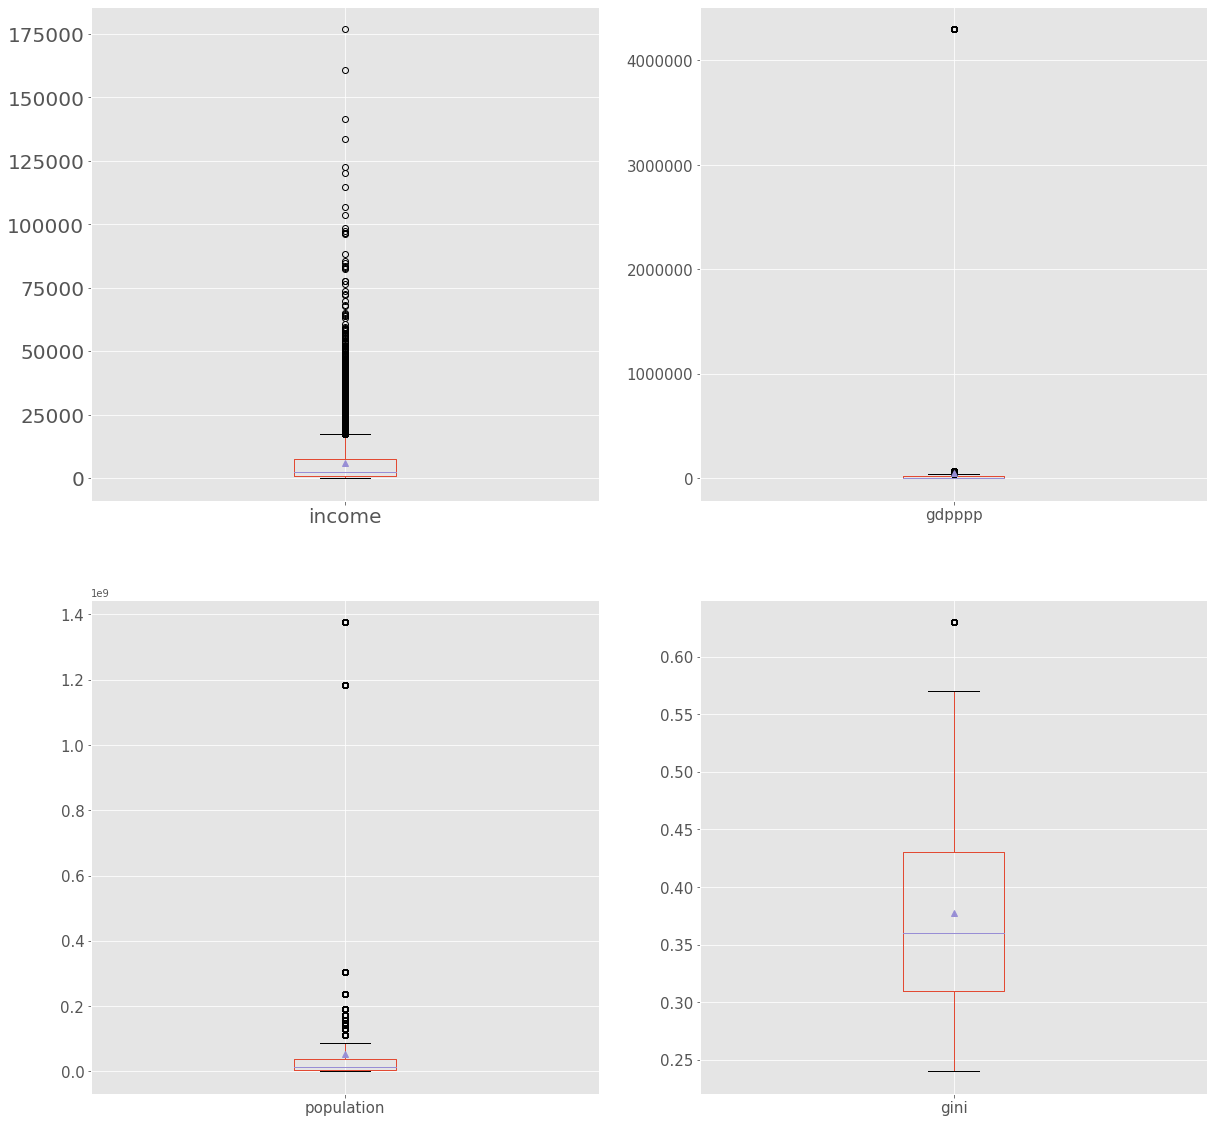

In [39]:
#Approche visuelle par Boxplot de la distribution des variables et des éventuels outliers
plt.figure(figsize=(20, 20))

plt.subplot(221)
df.iloc[:, [5]].boxplot(fontsize=20, widths=0.2, showmeans=True)
plt.subplot(222)
df.iloc[:, [6]].boxplot(fontsize=15, widths=0.2, showmeans=True)
plt.subplot(223)
df.iloc[:, [7]].boxplot(fontsize=15, widths=0.2, showmeans=True)
plt.subplot(224)
df.iloc[:, [8]].boxplot(fontsize=15, widths=0.2, showmeans=True)

plt.savefig('p7_graphic/variables_boxplot.jpg')
plt.show()

In [40]:
#Identification de quelques outliers afin de vérifier que ces valeurs puissent être possibles
display(df.sort_values(by='population', ascending=False).iloc[:1, :])
display(df.sort_values(by='gdpppp', ascending=False).iloc[:1, :])
display(df.sort_values(by='gini', ascending=False).iloc[:1, :])

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
1798,CHN,China,2007,99,100,11071.51,5712.0,1.376266e+09,0.48


,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
3200,FJI,Fiji,2008,1,100,308.17334,4300332.0,845361.0,0.4


,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
11400,ZAF,South Africa,2008,2,100,138.34155,9602.0,49779471.0,0.63


Les outliers sont des valeurs tout à fait cohérentes avec leur pays d'affectation. Il n'y a pas de surprise après vérification…

### Bilan des pays et des populations dans l'échantillon 

In [41]:
#Identification du nombre de pays par année 
#Recherche des années les plus représentatives…
demography_group = df[['year', 'country']].drop_duplicates().groupby('year').count().reset_index()
demography_group.rename(columns={'country':'country_quantity'}, inplace=True)
demography_group

,year,country_quantity
0,2004,1
1,2006,5
2,2007,15
3,2008,76
4,2009,12
5,2010,6
6,2011,1


In [42]:
#Intégration de la population selon les années de l'analyse
#Méthode .groupby() avec une somme des populations car nous avons une classification par quantile
pop_year = pd.DataFrame(df[df['quantile'] == 1].groupby(['year'])['population'].sum(), dtype=int).reset_index()
pop_year

,year,population
0,2004,17827825
1,2006,287548000
2,2007,2750266740
3,2008,2271976191
4,2009,475559459
5,2010,383832444
6,2011,14948801


In [43]:
#Intégration de la population mondiale par année
#Source https://donnees.banquemondiale.org/indicateur/SP.POP.TOTL
world_population = pd.read_csv('p7_data/world_population.csv', skiprows=3)
world_population = world_population[['Country Name', '2004', '2006', '2007', '2008', '2009', '2010', '2011']]
world_population = world_population[world_population['Country Name'] == 'Monde'].T.reset_index()
world_population.drop(world_population.index[0], inplace=True)
world_population.rename(columns={'index': 'year', 257: 'pop_world'}, inplace=True)

world_population = world_population.astype(int)
world_population

,year,pop_world
1,2004,6432374971
2,2006,6593623202
3,2007,6675130418
4,2008,6757887172
5,2009,6840591577
6,2010,6922947261
7,2011,7004011262


In [44]:
#Merge des populations avec pourcentage de la part mondiale
#Recherche des années les plus représentatives…
tab = pd.merge(demography_group, pop_year, on='year')
tab = pd.merge(tab, world_population, on='year')
tab['%world_pop'] = round((tab['population']/tab['pop_world']*100), 2)
tab

,year,country_quantity,population,pop_world,%world_pop
0,2004,1,17827825,6432374971,0.28
1,2006,5,287548000,6593623202,4.36
2,2007,15,2750266740,6675130418,41.20
3,2008,76,2271976191,6757887172,33.62
4,2009,12,475559459,6840591577,6.95
5,2010,6,383832444,6922947261,5.54
6,2011,1,14948801,7004011262,0.21


2007 et 2008 sont les deux seules années représentatives de l'échantillon.

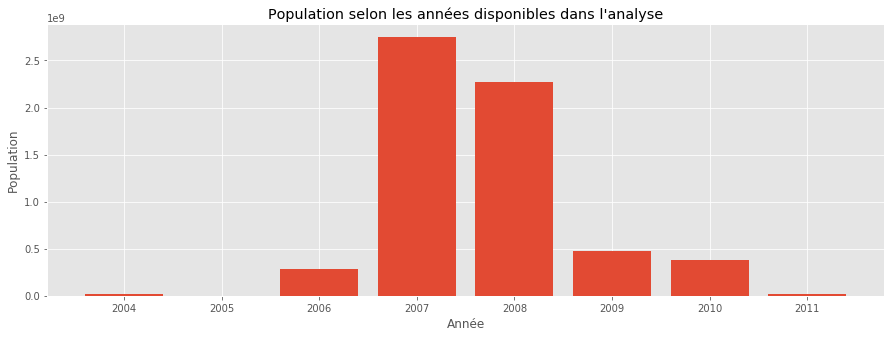

In [45]:
#Visualisation 
fig, ax = plt.subplots(figsize=(15,5))
plt.bar(tab['year'], tab['population'])

plt.xlabel('Année')
plt.ylabel('Population')
plt.title("Population selon les années disponibles dans l'analyse")

plt.savefig('p7_graphic/population_diagramme.jpg')
plt.show()

### Quelques chiffres et interprétation…

- Les années utilisées dans l'analyse vont de 2004 à 2011 (2005 non représentée).
- Une forte concentration sur les années **2007 et 2008**.
- **116 pays** représentés dans l'échantillon.
- Les quantiles utilisés pour l'ensemble des pays, par la World Income Distribution, sont des centiles (aussi appelés percentiles ).
- **La méthode des centiles** permet de réduire la taille de l'échantillon, tout en préservant suffisamment d'informations pour pouvoir l'analyser.
- Le $PPP est une unité qui permet de comparer le pouvoir d'achat entre deux pays sans distorsion due aux taux de change.

[Voir la suite du projet : Analyse de la diversité des pays, clustering, indice de Gini, courbe de Lorenz…](https://github.com/nalron/project_income_analysis/blob/french_version/p7_notebook02.ipynb)